<a href="https://colab.research.google.com/github/Shubhammt/cs6910_assignment2/blob/main/CS6910_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Downloading the dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/wandb_datasets/nature_12K.zip \
    -O /home/data.zip

--2022-03-23 14:19:52--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘/home/data.zip’

/home/data.zip      100%[===================>]   3.55G  71.9MB/s    in 40s     

2022-03-23 14:20:32 (91.3 MB/s) - ‘/home/data.zip’ saved [3816687935/3816687935]



In [6]:
import os
import zipfile

zip_path = '/home/data.zip'
#reading the zip file
zip_ref = zipfile.ZipFile(zip_path, 'r')
#extracting the zip file 
zip_ref.extractall('/home/dataset')
zip_ref.close()

In [7]:
train_dir = '/home/dataset/inaturalist_12K/train'
test_dir = '/home/dataset/inaturalist_12K/val'

In [6]:
wandb.login()

wandb: Currently logged in as: ma20m022 (use `wandb login --relogin` to force relogin)


True

In [7]:
wandb.init(project="Assignment 2", entity="shubham-argha")

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [8]:
#train_dir = 'C:/Users/729sh/Desktop/inaturalist_12K/train'
#test_dir = 'C:/Users/729sh/Desktop/inaturalist_12K/val'

# Dataset preparation

In [9]:
# train, test, validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.1,subset="training",seed=123,image_size=(128, 128), batch_size=16
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, validation_split=0.1,subset="validation",seed=123,image_size=(128, 128), batch_size=16
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(128, 128), batch_size=16
)

Found 9999 files belonging to 10 classes.
Using 9000 files for training.
Found 9999 files belonging to 10 classes.
Using 999 files for validation.
Found 2000 files belonging to 10 classes.


In [10]:
classes = train_ds.class_names
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [11]:
for image_batch, labels_batch in train_ds:
    first_image = image_batch[0]
    print(np.max(first_image))
    print(image_batch.shape)
    print(labels_batch.shape)
    break

254.77734
(16, 128, 128, 3)
(16,)


In [12]:
# Normalization 
norm_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (norm_layer(x), y))
val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))
test_ds = test_ds.map(lambda x, y: (norm_layer(x), y))

# Experiments

In [13]:
# sweep configuartion 
# method : random, bayes, grid
sweep_configuration = {
    'method': 'bayes', 
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'filter_shape':{
            'values': [[(3,3),(3,3),(3,3),(3,3),(3,3)], [(3, 3),(5,5),(3, 3),(3, 3),(3, 3)], [(5,5),(5,5),(5,5),(5,5),(5,5)], [(5, 5),(5,5),(3, 3),(3, 3),(3, 3)], [(3, 3),(5,5),(5, 5),(3, 3),(3, 3)]]
        },
        'dropout_probability': {
            'values': [0, 0.25, 0.20, 0.30]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'activation_function': {
            'values': ['relu']
        },
        'batch_normalization':{
            'values': ['true', 'false']
        },
        'filter_organization':{
            'values': [[64, 64, 128, 512, 512], [32, 64, 128, 512, 512], [32, 32, 64, 64, 128], [32, 64, 64, 128, 128], [32, 64, 128, 128, 512], [64, 64, 64, 64, 64], [512, 128, 128, 64, 32]]
        },
        'data_augmentation': {
            'values': ['true', 'false']
        },
        'FC_layer_size':{
            'values': [32, 64, 128, 256, 512]
        },
        'num_of_epochs':{
            'values': [10, 20]
        }
    }
}

In [14]:
# sweep initialization
#sweep_id : bstzh03n
sweep_id = wandb.sweep(sweep_configuration, entity="shubham-argha", project="Assignment 2")

Create sweep with ID: u80ny3a3
Sweep URL: https://wandb.ai/shubham-argha/Assignment%202/sweeps/u80ny3a3


In [15]:
def train():
    
    default_configuration = {
        'filter_shape': [(3, 3),(5,5),(3, 3),(3, 3),(3, 3)],
        'dropout_probability': 0.25,
        'learning_rate': 1e-3,
        'activation_function': 'relu',
        'num_of_epochs': 20,
        'batch_normalization': 'true',
        'filter_organization' : [32, 64, 128, 512, 512],
        'data_augmentation': 'false',
        'FC_layer_size': 256,
    }


    wandb.init(config=default_configuration)
    config = wandb.config
    wandb.run.name = 'fil_shape' + str(config.filter_shape) + '_fil_org' + str(config.filter_organization) + '_FC' + str(config.FC_layer_size) + '_drop' + str(config.dropout_probability) + '_batchnorm'

    
    # Model definition goes here
    def generate_model(input_shape,filter_shape, filter_organization, FC_layer_size, dropout_probability, activation):
        model = tf.keras.Sequential([
                                 
            # First CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[0], kernel_size = filter_shape[0], activation=activation,padding="same",input_shape=input_shape),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability),

            # Second CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[1], kernel_size = filter_shape[1], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability),

            # Third CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[2], kernel_size = filter_shape[2], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # Fourth CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[3], kernel_size = filter_shape[3], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # Fifth CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[4], kernel_size = filter_shape[4], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # FC layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(FC_layer_size, activation=activation),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(rate=dropout_probability),


            # Output layer
            tf.keras.layers.Dense(10, activation='softmax')
            ])
        return model


    filter_organization = config.filter_organization
    filter_shape = config.filter_shape
    FC_layer_size = config.FC_layer_size
    dropout_probability = config.dropout_probability
    activation = config.activation_function


    model = generate_model((128,128,3),filter_shape, filter_organization, FC_layer_size, dropout_probability, activation) 

    model.summary()
    
    model.compile(
        optimizer = keras.optimizers.Adam(config.learning_rate),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
    # data augmentation code
    if config.data_augmentation == 'true':
        datagenerator = ImageDataGenerator(
            rotation_range=45,                  #rotation
            width_shift_range=0.2,              #horizontal shift
            height_shift_range=0.1,             #vertical shift
            horizontal_flip=True,  
            vertical_flip=False  
        )
    else:
        datagenerator = ImageDataGenerator(rescale = 1.0)

    # datagenerator.fit(train_ds)
    # model.fit(
    #     datagen.flow(train_ds, val_ds, batch_size = 16),
    #     epochs = config.num_of_epochs,
    #     verbose = 1,
    #     validation_data= val_ds,
    #     callbacks = [WandbCallback()]
    # )
        
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.num_of_epochs,
        callbacks = [WandbCallback()]
        )
    

In [ ]:
wandb.agent('bstzh03n', train, count = 5)

# Best Model

In [16]:
def generate_model(input_shape,filter_shape, filter_organization, FC_layer_size, dropout_probability, activation):
        model = tf.keras.Sequential([
                                 
            # First CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[0], kernel_size = filter_shape[0], activation=activation,padding="same",input_shape=input_shape),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability),

            # Second CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[1], kernel_size = filter_shape[1], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability),

            # Third CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[2], kernel_size = filter_shape[2], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # Fourth CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[3], kernel_size = filter_shape[3], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # Fifth CONV layer
            tf.keras.layers.Conv2D(filters = filter_organization[4], kernel_size = filter_shape[4], activation=activation,padding="same"),
            keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
            keras.layers.Dropout(rate=dropout_probability), 

            # FC layer
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(FC_layer_size, activation=activation),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(rate=dropout_probability),


            # Output layer
            tf.keras.layers.Dense(10, activation='softmax')
            ])
        return model
best_model = generate_model((128,128,3),[(5, 5),(5,5),(3, 3),(3, 3),(3, 3)],  [64, 64,128, 512, 512], 512, 0.3, 'relu')

In [17]:
print(best_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       2

# Train and Save Best Model

In [18]:
best_model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'])
    
best_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10
        )

Epoch 1/10
563/563 [==============================] - 53s 80ms/step - loss: 2.5539 - accuracy: 0.1848 - val_loss: 2.2791 - val_accuracy: 0.1802
Epoch 2/10
563/563 [==============================] - 46s 81ms/step - loss: 2.2650 - accuracy: 0.2268 - val_loss: 2.2572 - val_accuracy: 0.2192
Epoch 3/10
563/563 [==============================] - 45s 79ms/step - loss: 2.1705 - accuracy: 0.2496 - val_loss: 2.2158 - val_accuracy: 0.2082
Epoch 4/10
563/563 [==============================] - 44s 78ms/step - loss: 2.0734 - accuracy: 0.2844 - val_loss: 2.4467 - val_accuracy: 0.2272
Epoch 5/10
563/563 [==============================] - 43s 76ms/step - loss: 2.0038 - accuracy: 0.3003 - val_loss: 2.0061 - val_accuracy: 0.2893
Epoch 6/10
563/563 [==============================] - 44s 77ms/step - loss: 1.9617 - accuracy: 0.3134 - val_loss: 2.3880 - val_accuracy: 0.2462
Epoch 7/10
563/563 [==============================] - 44s 77ms/step - loss: 1.9166 - accuracy: 0.3256 - val_loss: 1.8861 - val_accuracy:

In [19]:
best_model.save('best_model')

INFO:tensorflow:Assets written to: best_model\assets


In [20]:
best_model = keras.models.load_model('best_model')

In [21]:
results = best_model.evaluate(test_ds, batch_size=16)
print("test loss, test acc:", results)

125/125 [==============================] - 7s 50ms/step - loss: 1.9846 - accuracy: 0.3040
test loss, test acc: [1.9845738410949707, 0.30399999022483826]


# Visualisations

In [14]:
import os
import cv2
import random
random.seed(1)
test_images = []
test_labels = []
for label in range(10):
    imgs = os.listdir(test_dir+'/'+classes[label])
    disp_imgs = []
    for i in range(3):
        index = random.randint(0,199)
        disp_imgs.append(imgs[index])
    for img in disp_imgs:
        image = cv2.imread(test_dir+'/'+classes[label]+'/'+img)
        image = cv2.resize(image, (128, 128))
        test_images.append(image)
        test_labels.append(classes[label])
test_images = np.array(test_images)
test_images = test_images/255

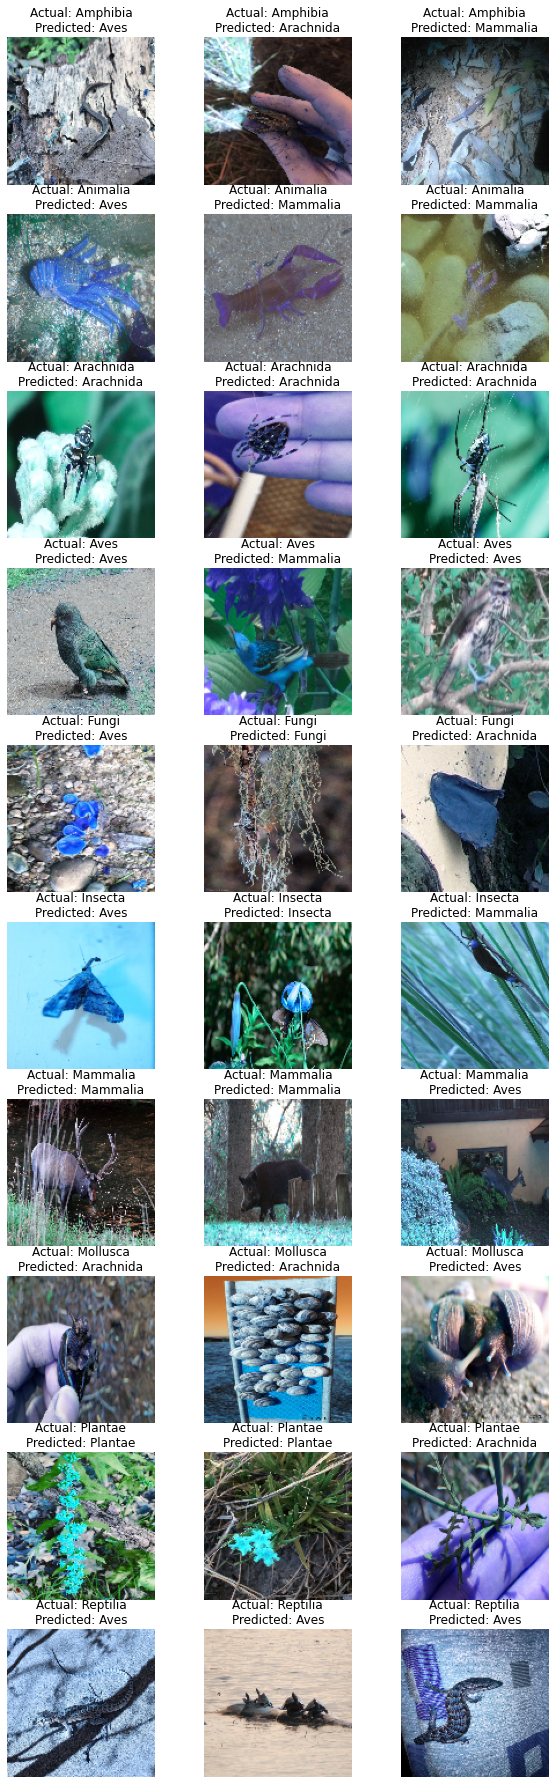

In [33]:
import matplotlib.pyplot as plt
figure = plt.figure(facecolor='white')
figure.set_figheight(32)
figure.set_figwidth(10)
index = 0
for i in range(10):
    for j in range(3):
        ax = plt.subplot(10,3,index+1)
        img = test_images[index]
        ax.imshow(img)
        prediction = best_model.predict(img.reshape(1,128, 128, 3))[0]
        label = test_labels[index]
        index+=1
        ax.axis('off')
        ax.set_title("Actual: " + label + "\nPredicted: " + classes[np.argmax(prediction)])
plt.savefig('test_grid.png',bbox_inches='tight')
plt.show()

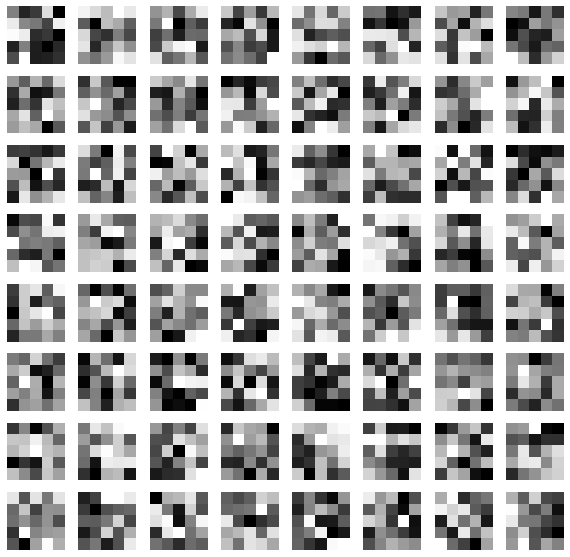

In [34]:
filters, biases = best_model.layers[0].get_weights()

# Normalize filter values to 0-1 
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plotting the figure
figure = plt.figure(facecolor='white')
figure.set_figheight(10)
figure.set_figwidth(10)

# plot first few filters
n_filters, ix = 64, 1
index = 0
for i in range(n_filters):
    f = filters[:, :, :, i]
    ax = plt.subplot(8,8,index+1)
    index+=1
    ax.imshow(f[:, :, 0], cmap='gray')
    ax.axis('off')
plt.savefig('filters.png',bbox_inches='tight')
plt.show()

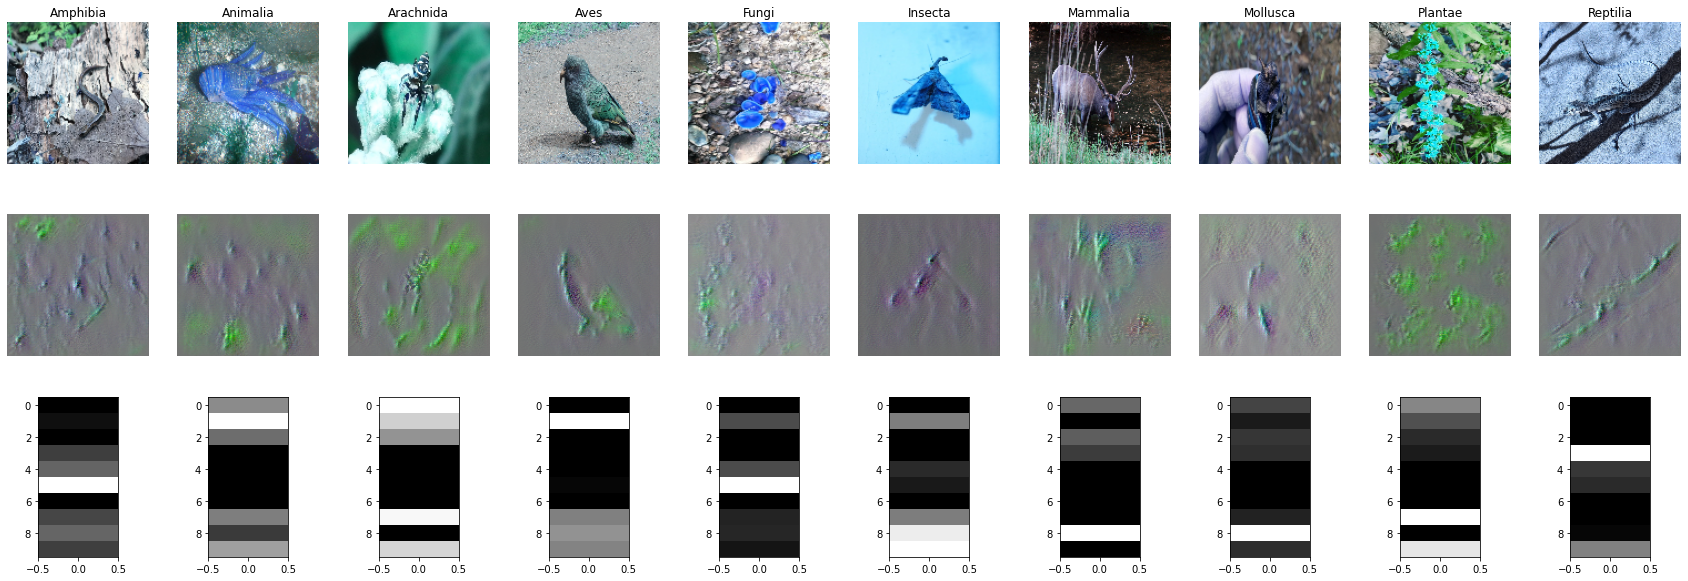

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
figure = plt.figure(facecolor='white')
figure.set_figheight(10)
figure.set_figwidth(30)


indices = [0,3,6,9,12,15,18,21,24,27]
cols = [0,0,0,0,0,0,0,0,0,0]
rows = [0,0,0,0,0,0,0,0,0,0]
channel = [0,0,0,0,0,0,0,0,0,0]
for i in range(10):
    index = indices[i]
    image = test_images[index]
    image_tensor = np.expand_dims(image, axis=0)
    ax = plt.subplot(3,10,i+1)
    ax.imshow(image_tensor[0])
    ax.axis('off')
    ax.set_title(test_labels[index])

    activation_model = tf.keras.models.Model([best_model.inputs],[best_model.get_layer("conv2d_4").output])


    @tf.custom_gradient
    def guidedRelU(x):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
        return tf.nn.relu(x), grad

    for layer in best_model.layers[1:]:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.selu:
            layer.activation = guidedRelU

    with tf.GradientTape() as g:
        inputs = tf.cast(image_tensor, tf.float32)
        g.watch(inputs)
        outputs = activation_model(inputs)[0]

    tar_grad = g.gradient(outputs,inputs)[0]

    CONV5_layer_activation = outputs

    layer_names = ['conv2d_4']

    display_grid = np.ones((10, 1))

    k = 7
    j = 1
    for c in range(10): 
        channel_image = CONV5_layer_activation[j, k, c]
        display_grid[c : (c + 1) , 0 : 1] = channel_image

    ax = plt.subplot(3,10,i+1+20)
    ax.grid(False)
    ax.imshow(display_grid,aspect=0.2,cmap='gray')                                         

    grad_img = np.dstack((
                tar_grad[:, :, 0],
                tar_grad[:, :, 1],
                tar_grad[:, :, 2],
            ))       
    grad_img = grad_img - np.min(grad_img)
    grad_img = grad_img/grad_img.max()
    ax = plt.subplot(3,10,i+1+10)
    imgplot = ax.imshow(grad_img)
    ax.axis("off")
plt.savefig('Guided_backprop.png',bbox_inches='tight')
plt.show() 